# The Annotated DeepDream

The idea of this notebook is to make it easy to get started with the [DeepDream algorithm](https://ai.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html)!

<img src="data/examples/figures_width_600_model_VGG16_IMAGENET_relu4_3_pyrsize_12_pyrratio_1.4_iter_10_lr_0.09_shift_32_resized500.jpg" alt="DeepDream example" align="center" style="width: 500px;"/> <br/>


In this notebook you'll learn how to create awesome **static DeepDream images** like the one above.

## So what is DeepDream in a nutshell?

DeepDream is an *artistic algorithm* where a **pretrained [CNN](https://en.wikipedia.org/wiki/Convolutional_neural_network)** is fed an image and *optimized* to **amplify the features** it "sees" in the image.

We do that by doing a **[gradient ascent](https://en.wikipedia.org/wiki/Gradient_descent)** on the (usually) **[MSE loss](https://en.wikipedia.org/wiki/Mean_squared_error)** constructed over the activations coming from a certain layer. The MSE is constructed between those activations and the all-0s tensor, which would by itself push the highest activations strongest towards zero, but by switching the sign, and doing a gradient ascent instead of descent, we end up amplyfing them the most!

Depending on the neural network layer the features amplified will either be **low level** (like edges, certain geometric patterns, etc.) or **high level** (like dog snouts, eyes, etc.) that heavily **depends on the dataset** on which the net was pretrained!

With that you're ready to start digging into the actual code! 💻

---

As a fun fact, I created [The AI Epiphany](http://youtube.com/c/TheAIEpiphany/)'s logo using this code:

<img src="data/examples/the_ai_epiphany/figures_width_960_model_RESNET50_PLACES_365_layer3_pyrsize_4_pyrratio_1.8_iter_10_lr_0.09_shift_40_resized500.jpg" alt="The AI Epiphany logo" align="center" style="width: 500px;"/> <br/>

Beautiful! 😍 We'll later see how you can reconstruct my logo yourself.

Let's get started!

# Part 1: Developing the DeepDream algorithm

In this notebook I'll be focusing on a single CNN: the **VGG16** (and I'll briefly touch upon ResNet50). You can see how the net architecture looks like below:

<img src="data/examples/jupyter/vgg16.png" alt="VGG 16 architecture" align="center" style="width: 700px;"/> <br/>

You have other awesome models at your disposal in this repository like: **ResNet50**, **GoogLeNet**, and **AlexNet** (AlexNet gives poor visualizations though 😐)

But I'll focus on a single model and hopefully you'll understand the main concepts! I'll also teach you how to experiment with this repo to create whatever you want.

Also as I mentioned, the dataset on which the net was trained really matters, and aside from **ImageNet** pretrained weights (which is fairly standard), ResNet50 and AlexNet have support for **[Places365](http://places2.csail.mit.edu/)** pretrained weights. You'll soon see how I did it and you can add support for other datasets! If you decide to do that and you get some beautiful, but different results, I strongly encourage you to [open up a PR](https://github.com/gordicaleksa/pytorch-deepdream/pulls)! (I just beg you to adhere to the coding style of this repo) ❤️

Ok, enough talk! Let's dig into the code and first define some imports that we'll need: 

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
# I always like to structure my imports into Python's native libs,
# stuff I installed via conda/pip and local file imports (but we don't have those here)

# Python native libs
import os
import enum
from collections import namedtuple
import argparse
import numbers
import math


# Deep learning related imports
import torch
import torch.nn as nn
from torchvision import models
from torchvision import transforms
import torch.nn.functional as F


import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt  # visualizations

In [3]:
RUNALLEXAMPLES = False

Now define some enums and constants that will come in handy:

In [4]:
# The 2 datasets we'll be leveraging
class SupportedPretrainedWeights(enum.Enum):
    IMAGENET = 0
    PLACES_365 = 1
    NSFW = 2
    

# The 2 models we'll be using
class SupportedModels(enum.Enum):
    VGG16_EXPERIMENTAL = 0,
    RESNET50 = 1
    

# Commonly used paths, let's define them here as constants
DATA_DIR_PATH = os.path.join(os.getcwd(), 'data')
INPUT_DATA_PATH = os.path.join(DATA_DIR_PATH, 'input')
BINARIES_PATH = os.path.join(os.getcwd(), 'models', 'binaries')
OUT_IMAGES_PATH = os.path.join(DATA_DIR_PATH, 'out-images')

# Make sure these exist as the rest of the code relies on it
os.makedirs(BINARIES_PATH, exist_ok=True)
os.makedirs(OUT_IMAGES_PATH, exist_ok=True)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.has_mps else "cpu")  # checking whether you have a GPU

# Images will be normalized using these, because the CNNs were trained with normalized images as well!
IMAGENET_MEAN_1 = np.array([0.485, 0.456, 0.406], dtype=np.float32)
IMAGENET_STD_1 = np.array([0.229, 0.224, 0.225], dtype=np.float32)

With that out of the way we've got the level 1 unlocked (exposing model activations 🦄). 😍 Let's go!

## Exposing neural network's activations 🦄
Nice! Now let's expose the activations coming from the VGG16 as we'll need those later and you'll soon understand exactly why:

In [5]:
class Vgg16Experimental(torch.nn.Module):
    
    def __init__(self, pretrained_weights, requires_grad=False, show_progress=False):
        super().__init__()

        # Only ImageNet weights are supported for now for this model
        if pretrained_weights == SupportedPretrainedWeights.IMAGENET.name:
            vgg16 = models.vgg16(pretrained=True, progress=show_progress).eval()
        else:
            raise Exception(f'Pretrained weights {pretrained_weights} not yet supported for {self.__class__.__name__} model.')

        # I just used the official PyTorch implementation to figure out how to dissect VGG16:
        # https://github.com/pytorch/vision/blob/master/torchvision/models/vgg.py
        vgg_pretrained_features = vgg16.features

        # I've exposed the best/most interesting layers in my subjective opinion (mp5 is not that good though)
        self.layer_names = ['relu3_3', 'relu4_1', 'relu4_2', 'relu4_3', 'relu5_1', 'relu5_2', 'relu5_3', 'mp5']

        # 31 layers in total for the VGG16
        self.conv1_1 = vgg_pretrained_features[0]
        self.relu1_1 = vgg_pretrained_features[1]
        self.conv1_2 = vgg_pretrained_features[2]
        self.relu1_2 = vgg_pretrained_features[3]
        self.max_pooling1 = vgg_pretrained_features[4]
        self.conv2_1 = vgg_pretrained_features[5]
        self.relu2_1 = vgg_pretrained_features[6]
        self.conv2_2 = vgg_pretrained_features[7]
        self.relu2_2 = vgg_pretrained_features[8]
        self.max_pooling2 = vgg_pretrained_features[9]
        self.conv3_1 = vgg_pretrained_features[10]
        self.relu3_1 = vgg_pretrained_features[11]
        self.conv3_2 = vgg_pretrained_features[12]
        self.relu3_2 = vgg_pretrained_features[13]
        self.conv3_3 = vgg_pretrained_features[14]
        self.relu3_3 = vgg_pretrained_features[15]
        self.max_pooling3 = vgg_pretrained_features[16]
        self.conv4_1 = vgg_pretrained_features[17]
        self.relu4_1 = vgg_pretrained_features[18]
        self.conv4_2 = vgg_pretrained_features[19]
        self.relu4_2 = vgg_pretrained_features[20]
        self.conv4_3 = vgg_pretrained_features[21]
        self.relu4_3 = vgg_pretrained_features[22]
        self.max_pooling4 = vgg_pretrained_features[23]
        self.conv5_1 = vgg_pretrained_features[24]
        self.relu5_1 = vgg_pretrained_features[25]
        self.conv5_2 = vgg_pretrained_features[26]
        self.relu5_2 = vgg_pretrained_features[27]
        self.conv5_3 = vgg_pretrained_features[28]
        self.relu5_3 = vgg_pretrained_features[29]
        self.max_pooling5 = vgg_pretrained_features[30]

        # Turn off these because we'll be using a pretrained network
        # if we didn't do this PyTorch would be saving gradients and eating up precious memory!
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

    # Just expose every single layer during the forward pass
    def forward(self, x):
        x = self.conv1_1(x)
        conv1_1 = x
        x = self.relu1_1(x)
        relu1_1 = x
        x = self.conv1_2(x)
        conv1_2 = x
        x = self.relu1_2(x)
        relu1_2 = x
        x = self.max_pooling1(x)
        x = self.conv2_1(x)
        conv2_1 = x
        x = self.relu2_1(x)
        relu2_1 = x
        x = self.conv2_2(x)
        conv2_2 = x
        x = self.relu2_2(x)
        relu2_2 = x
        x = self.max_pooling2(x)
        x = self.conv3_1(x)
        conv3_1 = x
        x = self.relu3_1(x)
        relu3_1 = x
        x = self.conv3_2(x)
        conv3_2 = x
        x = self.relu3_2(x)
        relu3_2 = x
        x = self.conv3_3(x)
        conv3_3 = x
        x = self.relu3_3(x)
        relu3_3 = x
        x = self.max_pooling3(x)
        x = self.conv4_1(x)
        conv4_1 = x
        x = self.relu4_1(x)
        relu4_1 = x
        x = self.conv4_2(x)
        conv4_2 = x
        x = self.relu4_2(x)
        relu4_2 = x
        x = self.conv4_3(x)
        conv4_3 = x
        x = self.relu4_3(x)
        relu4_3 = x
        x = self.max_pooling4(x)
        x = self.conv5_1(x)
        conv5_1 = x
        x = self.relu5_1(x)
        relu5_1 = x
        x = self.conv5_2(x)
        conv5_2 = x
        x = self.relu5_2(x)
        relu5_2 = x
        x = self.conv5_3(x)
        conv5_3 = x
        x = self.relu5_3(x)
        relu5_3 = x
        mp5 = self.max_pooling5(x)

        # Finally, expose only the layers that you want to experiment with here
        vgg_outputs = namedtuple("VggOutputs", self.layer_names)
        out = vgg_outputs(relu3_3, relu4_1, relu4_2, relu4_3, relu5_1, relu5_2, relu5_3, mp5)

        return out
    
    
def fetch_and_prepare_model(model_type, pretrained_weights):
    if model_type == SupportedModels.VGG16_EXPERIMENTAL.name:
        model = Vgg16Experimental(pretrained_weights, requires_grad=False, show_progress=True).to(DEVICE)
    elif model_type == SupportedModels.RESNET50.name:
        # We'll define the ResNet50 later
        model = ResNet50(pretrained_weights, requires_grad=False, show_progress=True).to(DEVICE)
    else:
        raise Exception('Model not yet supported.')
    return model

Nice as you can see VGG16 is just a bunch of **convolutions** and **ReLUs** followed by occasional **max pooling** layers.
Doesn't get much simpler than this!

I'll assume in this notebook that you're familiar with what these are, but even if you're not you can just treat them as a black box. ⬛

---

✅ exposing model activations

## Image loading, saving and displaying 🖼️



Let's now define some image utility functions that will handle data (images) loading, saving and plotting!

In [6]:
def load_image(img_path, target_shape=None):
    if not os.path.exists(img_path):
        raise Exception(f'Path does not exist: {img_path}')
    img = cv.imread(img_path)[:, :, ::-1]  # [:, :, ::-1] converts BGR (opencv format...) into RGB

    if target_shape is not None:  # resize section
        if isinstance(target_shape, int) and target_shape != -1:  # scalar -> implicitly setting the width
            current_height, current_width = img.shape[:2]
            new_width = target_shape
            new_height = int(current_height * (new_width / current_width))
            img = cv.resize(img, (new_width, new_height), interpolation=cv.INTER_CUBIC)
        else:  # set both dimensions to target shape
            img = cv.resize(img, (target_shape[1], target_shape[0]), interpolation=cv.INTER_CUBIC)

    # This need to go after resizing - otherwise cv.resize will push values outside of [0,1] range
    img = img.astype(np.float32)  # convert from uint8 to float32
    img /= 255.0  # get to [0, 1] range
    return img


# config is just a shared dictionary that you'll be seeing used everywhere, but we'll define it a bit later.
# For the time being think of it as an oracle - whatever the function needs - config provides ^^
def save_and_maybe_display_image(config, dump_img, name_modifier=None):
    assert isinstance(dump_img, np.ndarray), f'Expected numpy array got {type(dump_img)}.'

    # Step 1: figure out the dump dir location
    dump_dir = config['dump_dir']
    os.makedirs(dump_dir, exist_ok=True)

    # Step 2: define the output image name
    if name_modifier is not None:
        dump_img_name = str(name_modifier).zfill(6) + '.jpg'
    else:
        dump_img_name = build_image_name(config)

    if dump_img.dtype != np.uint8:
        dump_img = (dump_img*255).astype(np.uint8)

    # Step 3: write image to the file system
    # ::-1 because opencv expects BGR (and not RGB) format...
    dump_path = os.path.join(dump_dir, dump_img_name)
    cv.imwrite(dump_path, dump_img[:, :, ::-1])

    # Step 4: potentially display/plot the image
    if config['should_display']:
        fig = plt.figure(figsize=(7.5,5), dpi=100)  # otherwise plots are really small in Jupyter Notebook
        plt.axis('off')
        plt.imshow(dump_img)
        plt.show()

    return dump_path


# This function makes sure we can later reconstruct the image using the information encoded into the filename!
# Again don't worry about all the arguments we'll define them later
def build_image_name(config):
    input_name = 'rand_noise' if config['use_noise'] else config['input'].split('.')[0]
    layers = '_'.join(config['layers_to_use'])
    # Looks awful but makes the creation process transparent for other creators
    img_name = f'{input_name}_width_{config["img_width"]}_model_{config["model_name"]}_{config["pretrained_weights"]}_{layers}_pyrsize_{config["pyramid_size"]}_pyrratio_{config["pyramid_ratio"]}_iter_{config["num_gradient_ascent_iterations"]}_lr_{config["lr"]}_shift_{config["spatial_shift_size"]}_smooth_{config["smoothing_coefficient"]}.jpg'
    return img_name

Awesome! Let's test the code as we progress, to make sure it works the way we expect it to (without any 🐛🐛🐛):

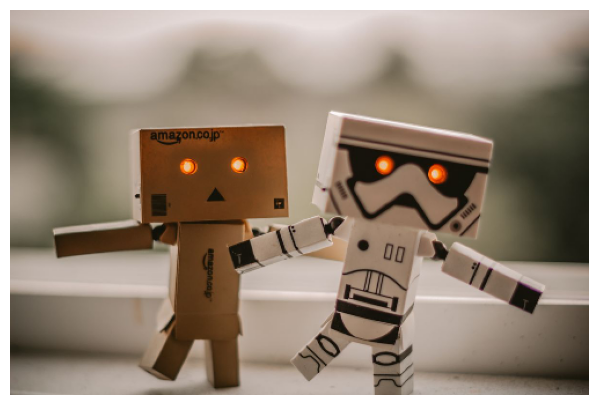

In [7]:
input_img_name = 'figures.jpg'  # checked in, I'll be using it as the running example
img_width = 500  # arbitrary
img_path = os.path.join(INPUT_DATA_PATH, input_img_name)
img = load_image(img_path, target_shape=img_width)

fig = plt.figure(figsize=(7.5,5), dpi=100)  # otherwise plots are really small in Jupyter Notebook
plt.axis('off')
plt.imshow(img)
plt.show()

✅ Image loading works like a charm! 

We'll test `save_and_maybe_display_image` a bit later (we need that config!).

## DeepDream image/tensor utilities

Now before jumping straight into the core of the algorithm let's define a couple more functions that we'll need, run the following cell:

In [8]:
# mean/std normalization - ImageNet's mean and std capture the statistics of natural images pretty nicely.
# This works for Places365 dataset as well (keep in mind you might have to change it if your dataset is way different)
def pre_process_numpy_img(img):
    assert isinstance(img, np.ndarray), f'Expected numpy image got {type(img)}'

    img = (img - IMAGENET_MEAN_1) / IMAGENET_STD_1  # normalize image
    return img


def post_process_numpy_img(img):
    assert isinstance(img, np.ndarray), f'Expected numpy image got {type(img)}'

    if img.shape[0] == 3:  # if channel-first format move to channel-last (CHW -> HWC)
        img = np.moveaxis(img, 0, 2)

    mean = IMAGENET_MEAN_1.reshape(1, 1, -1)
    std = IMAGENET_STD_1.reshape(1, 1, -1)
    img = (img * std) + mean  # de-normalize
    img = np.clip(img, 0., 1.)  # make sure it's in the [0, 1] range

    return img


def pytorch_input_adapter(img):
    # shape = (1, 3, H, W)
    tensor = transforms.ToTensor()(img).to(DEVICE).unsqueeze(0)
    tensor.requires_grad = True  # we need to collect gradients for the input image
    return tensor


def pytorch_output_adapter(tensor):
    # Push to CPU, detach from the computational graph, convert from (1, 3, H, W) tensor into (H, W, 3) numpy image
    return np.moveaxis(tensor.to('cpu').detach().numpy()[0], 0, 2)


# Adds stochasticity to the algorithm and makes the results more diverse
def random_circular_spatial_shift(tensor, h_shift, w_shift, should_undo=False):
    if should_undo:
        h_shift = -h_shift
        w_shift = -w_shift
    with torch.no_grad():
        rolled = torch.roll(tensor, shifts=(h_shift, w_shift), dims=(2, 3))
        rolled.requires_grad = True
        return rolled

With those out of the way, let me now tell you a bit more about pyramids. Pyramids were build in Egypt for ... wait what? 😮

That's not the pyramid I'm talking about, let's see what I mean by **pyramid**! (if you're not already familiar with the concept)

## Image pyramid

I mentioned in my initial explanation of DeepDream that the image will be fed through the CNN and that it will amplify *certain* features.

There is one important, practical detail that I've omitted and that's that we'll be feeding the image in various resolutions into the CNN. By doing that the network will see different things each time and that will in return give us a richer output.

**Note:** (for nerds 🤓) *that happens because the ratio between the **receptive field** of the CNN and the input image changes and thus sometimes the net will see the entire image and thus can create global features and in other cases it will see a small portion of the image and it can focus more on the texture.*

In order to feed multiple resolutions in, we'll need to define something called an **image pyramid**.

Let's see what an image pyramid is (it'll be easier to explain that way):

<img src="data/examples/jupyter/image_pyramid.png" alt="Image pyramid" align="center" style="width: 350px;"/> <br/>

Awesome. Now what you can see here is the following, the input image like `figures.jpg` that we've been using will be **resized to multiple resolutions** and passed through the DeepDream algorithm. Depending on the resolution the neural network will **amplify different features**. It's a very common technique used all over *digital image processing* 📷 and *classical computer vision* 💻 worlds (pre-deep learning era kids! 🤓).

---

Let's define a helper function that will calculate the image resolution depending on the pyramid level we're at.

* `pyramid_size` - controls the number of pyramid levels (**5** in the image above)
* `pyramid_ratio` - ratio of the resolutions in the pyramid. 2x means 400x400 image becomes 200x200 on the next level.

In [9]:
# again treat config as an oracle
def get_new_shape(config, original_shape, current_pyramid_level):
    SHAPE_MARGIN = 10
    pyramid_ratio = config['pyramid_ratio']
    pyramid_size = config['pyramid_size']
    exponent = current_pyramid_level - pyramid_size + 1  # this one will be negative so we're dividing the original img shape
    new_shape = np.round(np.float32(original_shape) * (pyramid_ratio**exponent)).astype(np.int32)

    if new_shape[0] < SHAPE_MARGIN or new_shape[1] < SHAPE_MARGIN:
        print(f'Pyramid size {config["pyramid_size"]} with pyramid ratio {config["pyramid_ratio"]} gives too small pyramid levels with size={new_shape}')
        print(f'Please change the parameters.')
        exit(0)

    return new_shape

We're now ready to dive into the core of the algorithm!!! 🎉🎉🎉

## DeepDream core algorithm

So this is the core part. Take some time to understand what is happening. We'll define `gradient_ascent` in the next cell.

In [10]:
def deep_dream_static_image(config, img=None):
    model = fetch_and_prepare_model(config['model_name'], config['pretrained_weights'])

    try:
        layer_ids_to_use = [model.layer_names.index(layer_name) for layer_name in config['layers_to_use']]
    except Exception as e:  # making sure you set the correct layer name for this specific model
        print(f'Invalid layer names {[layer_name for layer_name in config["layers_to_use"]]}.')
        print(f'Available layers for model {config["model_name"]} are {model.layer_names}.')
        return

    if img is None:  # load either the provided image or start from a pure noise image
        img_path = os.path.join(INPUT_DATA_PATH, config['input'])
        # load a numpy, [0, 1] range, channel-last, RGB image
        img = load_image(img_path, target_shape=config['img_width'])
        if config['use_noise']:
            shape = img.shape
            img = np.random.uniform(low=0.0, high=1.0, size=shape).astype(np.float32)

    img = pre_process_numpy_img(img)
    original_shape = img.shape[:-1]  # save initial height and width

    # Note: simply rescaling the whole result (and not only details, see original implementation) gave me better results
    # Going from smaller to bigger resolution (from pyramid top to bottom)
    for pyramid_level in range(config['pyramid_size']):
        new_shape = get_new_shape(config, original_shape, pyramid_level)
        img = cv.resize(img, (new_shape[1], new_shape[0]))  # resize depending on the current pyramid level
        input_tensor = pytorch_input_adapter(img)  # convert to trainable tensor

        for iteration in range(config['num_gradient_ascent_iterations']):

            # Introduce some randomness, it will give us more diverse results especially when you're making videos
            h_shift, w_shift = np.random.randint(-config['spatial_shift_size'], config['spatial_shift_size'] + 1, 2)
            input_tensor = random_circular_spatial_shift(input_tensor, h_shift, w_shift)

            # This is where the magic happens, treat it as a black box until the next cell
            gradient_ascent(config, model, input_tensor, layer_ids_to_use, iteration)

            # Roll back by the same amount as above (hence should_undo=True)
            input_tensor = random_circular_spatial_shift(input_tensor, h_shift, w_shift, should_undo=True)

        img = pytorch_output_adapter(input_tensor)

    return post_process_numpy_img(img)

And finally this is where the magic happens!

In [11]:
LOWER_IMAGE_BOUND = torch.tensor((-IMAGENET_MEAN_1 / IMAGENET_STD_1).reshape(1, -1, 1, 1)).to(DEVICE)
UPPER_IMAGE_BOUND = torch.tensor(((1 - IMAGENET_MEAN_1) / IMAGENET_STD_1).reshape(1, -1, 1, 1)).to(DEVICE)


def gradient_ascent(config, model, input_tensor, layer_ids_to_use, iteration):
    # Step 0: Feed forward pass
    out = model(input_tensor)

    # Step 1: Grab activations/feature maps of interest
    activations = [out[layer_id_to_use] for layer_id_to_use in layer_ids_to_use]

    # Step 2: Calculate loss over activations
    losses = []
    for layer_activation in activations:
        # Use torch.norm(torch.flatten(layer_activation), p) with p=2 for L2 loss and p=1 for L1 loss. 
        # But I'll use the MSE as it works really good, I didn't notice any serious change when going to L1/L2.
        # using torch.zeros_like as if we wanted to make activations as small as possible but we'll do gradient ascent
        # and that will cause it to actually amplify whatever the network "sees" thus yielding the famous DeepDream look
        zeros = torch.zeros_like(layer_activation)
        zeros = torch.ones_like(layer_activation)
        try:
            try:
                zeros[0,70]    = torch.zeros_like(layer_activation[0,0])
                zeros[0,189]   = torch.zeros_like(layer_activation[0,0])
                zeros[0,213]   = torch.zeros_like(layer_activation[0,0])
                zeros[0,262]   = torch.zeros_like(layer_activation[0,0])
                zeros[0,140]   = torch.zeros_like(layer_activation[0,0])
                zeros[0,345]   = torch.zeros_like(layer_activation[0,0])
                zeros[0,240]   = torch.zeros_like(layer_activation[0,0])
                zeros[0,38]    = torch.zeros_like(layer_activation[0,0])
                zeros[0,283]   = torch.zeros_like(layer_activation[0,0])
                zeros[0,295]   = torch.zeros_like(layer_activation[0,0])
                zeros[0,5]     = torch.zeros_like(layer_activation[0,0])
                zeros[0,450]   = torch.zeros_like(layer_activation[0,0])
                zeros[0,308]   = torch.zeros_like(layer_activation[0,0])

                # zeros = torch.ones_like(layer_activation)*0.2
                # zeros[0,295] = torch.zeros_like(layer_activation[0][0])
            except:
                zeros[0,4] = torch.zeros_like(layer_activation[0][0])
                zeros[0,1] = torch.zeros_like(layer_activation[0][0])
                zeros[0,3] = torch.zeros_like(layer_activation[0][0])
        except:
            print(f"ailed{zeros}")
        loss_component = torch.nn.MSELoss(reduction='mean')(layer_activation, zeros)
        losses.append(loss_component)

    loss = torch.mean(torch.stack(losses))
    loss.backward()

    # Step 3: Process image gradients (smoothing + normalization, more an art then a science)
    grad = input_tensor.grad.data

    # Applies 3 Gaussian kernels and thus "blurs" or smoothens the gradients and gives visually more pleasing results
    # We'll see the details of this one in the next cell and that's all, you now understand DeepDream!
    sigma = ((iteration + 1) / config['num_gradient_ascent_iterations']) * 2.0 + config['smoothing_coefficient']
    smooth_grad = CascadeGaussianSmoothing(kernel_size=9, sigma=sigma)(grad) if config['smoothing_coefficient'] >0 else grad # "magic number" 9 just works well

    # Normalize the gradients (make them have mean = 0 and std = 1)
    # I didn't notice any big difference normalizing the mean as well - feel free to experiment
    g_std = torch.std(smooth_grad)
    g_mean = torch.mean(smooth_grad)
    smooth_grad = smooth_grad - g_mean
    smooth_grad = smooth_grad / g_std

    # Step 4: Update image using the calculated gradients (gradient ascent step)
    input_tensor.data += config['lr'] * smooth_grad

    # Step 5: Clear gradients and clamp the data (otherwise values would explode to +- "infinity")
    input_tensor.grad.data.zero_()
    input_tensor.data = torch.max(torch.min(input_tensor, UPPER_IMAGE_BOUND), LOWER_IMAGE_BOUND)

*Note for uber nerds:* 🤓 <br/>
*loss.backward(layer) <- original implementation did it like this and it's equivalent to MSE(reduction='sum')/2. Check out my [playground.py](https://github.com/gordicaleksa/pytorch-deepdream/blob/master/playground.py#L95) for more details*

Finally let us see how the **gradient smoothing** via the Gaussian is implemented:

In [12]:
class CascadeGaussianSmoothing(nn.Module):
    """
    Apply gaussian smoothing separately for each channel (depthwise convolution).

    Arguments:
        kernel_size (int, sequence): Size of the gaussian kernel.
        sigma (float, sequence): Standard deviation of the gaussian kernel.

    """
    def __init__(self, kernel_size, sigma):
        super().__init__()

        if isinstance(kernel_size, numbers.Number):
            kernel_size = [kernel_size, kernel_size]

        cascade_coefficients = [0.5, 1.0, 2.0]  # std multipliers, hardcoded to use 3 different Gaussian kernels
        sigmas = [[coeff * sigma, coeff * sigma] for coeff in cascade_coefficients]  # isotropic Gaussian

        self.pad = int(kernel_size[0] / 2)  # assure we have the same spatial resolution

        # The gaussian kernel is the product of the gaussian function of each dimension.
        kernels = []
        meshgrids = torch.meshgrid([torch.arange(size, dtype=torch.float32) for size in kernel_size])
        for sigma in sigmas:
            kernel = torch.ones_like(meshgrids[0])
            for size_1d, std_1d, grid in zip(kernel_size, sigma, meshgrids):
                mean = (size_1d - 1) / 2
                kernel *= 1 / (std_1d * math.sqrt(2 * math.pi)) * torch.exp(-((grid - mean) / std_1d) ** 2 / 2)
            kernels.append(kernel)

        gaussian_kernels = []
        for kernel in kernels:
            # Normalize - make sure sum of values in gaussian kernel equals 1.
            kernel = kernel / torch.sum(kernel)
            # Reshape to depthwise convolutional weight
            kernel = kernel.view(1, 1, *kernel.shape)
            kernel = kernel.repeat(3, 1, 1, 1)
            kernel = kernel.to(DEVICE)

            gaussian_kernels.append(kernel)

        self.weight1 = gaussian_kernels[0]
        self.weight2 = gaussian_kernels[1]
        self.weight3 = gaussian_kernels[2]
        self.conv = F.conv2d

    def forward(self, input):
        input = F.pad(input, [self.pad, self.pad, self.pad, self.pad], mode='reflect')

        # Apply Gaussian kernels depthwise over the input (hence groups equals the number of input channels)
        # shape = (1, 3, H, W) -> (1, 3, H, W)
        num_in_channels = input.shape[1]
        grad1 = self.conv(input, weight=self.weight1, groups=num_in_channels)
        grad2 = self.conv(input, weight=self.weight2, groups=num_in_channels)
        grad3 = self.conv(input, weight=self.weight3, groups=num_in_channels)

        return (grad1 + grad2 + grad3) / 3

What it does is it creates three **9x9 Gaussian kernels** and it applies them, **depthwise**, over the input gradients.

Kernel 1 is applied to channels 1, 2 and 3 and it preserves the shape i.e. we go from (1, 3, H, W) to (1, 3, H, W). <br/>
Similarly for kernels 2 and 3 and then we just combine the output by taking a mean.

---

Phew! That was a mouthful. 🎉🎉🎉

Take your time and **be patient**! Especially if you're new to CNNs.

I didn't learn all of this in 1 day, it takes time for the knowledge to sink in. You'll get there as well! ❤️ (if you're not already there 😜)

✅ Understand the DeepDream algorithm

---

Now let's finally define that **config** oracle we've been seeing thrown all around.

## Input arguments and run the damn thing

In [13]:
# Only a small subset is exposed by design to avoid cluttering
parser = argparse.ArgumentParser()

# Common params
parser.add_argument("--input", type=str, help="Input IMAGE or VIDEO name that will be used for dreaming", default='figures.jpg')
parser.add_argument("--img_width", type=int, help="Resize input image to this width", default=600)
parser.add_argument("--layers_to_use", type=str, nargs='+', help="Layer whose activations we should maximize while dreaming", default=['relu4_3'])
parser.add_argument("--model_name", choices=[m.name for m in SupportedModels],
                    help="Neural network (model) to use for dreaming", default=SupportedModels.VGG16_EXPERIMENTAL.name)
parser.add_argument("--pretrained_weights", choices=[pw.name for pw in SupportedPretrainedWeights],
                    help="Pretrained weights to use for the above model", default=SupportedPretrainedWeights.IMAGENET.name)

# Main params for experimentation (especially pyramid_size and pyramid_ratio)
parser.add_argument("--pyramid_size", type=int, help="Number of images in an image pyramid", default=4)
parser.add_argument("--pyramid_ratio", type=float, help="Ratio of image sizes in the pyramid", default=1.8)
parser.add_argument("--num_gradient_ascent_iterations", type=int, help="Number of gradient ascent iterations", default=10)
parser.add_argument("--lr", type=float, help="Learning rate i.e. step size in gradient ascent", default=0.09)

# You usually won't need to change these as often
parser.add_argument("--should_display", type=bool, help="Display intermediate dreaming results", default=False)
parser.add_argument("--spatial_shift_size", type=int, help='Number of pixels to randomly shift image before grad ascent', default=32)
parser.add_argument("--smoothing_coefficient", type=float, help='Directly controls standard deviation for gradient smoothing', default=0.5)
parser.add_argument("--use_noise", type=bool, help="Use noise as a starting point instead of input image", default=False)
args = parser.parse_args('')  # important to put '' in Jupyter otherwise it will complain

# Wrapping configuration into a dictionary
config = dict()
for arg in vars(args):
    config[arg] = getattr(args, arg)
config['dump_dir'] = os.path.join(OUT_IMAGES_PATH, f'{config["model_name"]}_{config["pretrained_weights"]}')
config['input'] = os.path.basename(config['input'])  # handle absolute and relative paths

You should be familiar with these at this point.

In the **first group of params** we're picking the image we'll be "dreaming over", the output image width, which layers/activations should we use to amplify the features, and finally which CNN model and which pretrained weights should we use?

The **second group** controls the optimization: the pyramid control parameters, number of optimization steps and the learning rate.

You probably won't experiment that much with the **third group of parameters**. The `smoothing coefficient` might hold some promise I didn't experiment that much with it.

Finally let's run it, and enjoy the fruits of our labor! 😍

In [14]:
config['should_display'] = True

if RUNALLEXAMPLES:
    img = deep_dream_static_image(config)  # yep a single liner


    dump_path = save_and_maybe_display_image(config, img)
    print(f'Saved DeepDream static image to: {os.path.relpath(dump_path)}\n')

WooOOOooooHhhOOooooo! ❤️ This is probably one of my favourite algorithms.

Who would have known that neural nets had this hidden inside them???

---

**Congrats!** you went through the hardest part of understanding how DeepDream actually works! 😍

Having said that I have to confess. 

If your only goal is to create beautiful artistic imagery, you don't necessarily need to understand how it works under the hood! Don't be mad at me. ❤️ 

That understanding can still help you make smarter decisions as you'll soon see.

The next section will give you the power to create awesome images. For free. On your computer. And very fast! (at least on my machine - RTX 2080 😂) 

# Part 2: Experimenting with static DeepDream images

Let me now show you how you can tweak the DeepDream settings. ⚙️

Once you get the feeling for how it works, you'll be much more capable to produce the imagery that you want! 🎨

---

Setting 1: `use_noise` 😍

Instead of using a specified image like `figures.jpg`, which I've been using as the running example, you can initialize the algorithm with pure noise:

In [15]:
if RUNALLEXAMPLES:
    config['use_noise'] = True  # variable under test

    img = deep_dream_static_image(config)
    dump_path = save_and_maybe_display_image(config, img)
    print(f'Saved DeepDream static image to: {os.path.relpath(dump_path)}\n')

    config['use_noise'] = False  # keep the config consistent from cell to cell

No trace of the `figures.jpg` image! The results are much less predictable. TBH, I rarely used it, but in combination with other arguments it may give you some surprising results!

---

Setting 2: `layers_to_use` 😍

So far we've been using VGG16's `relu4_3` layer. 

Depending on the layer you choose you'll amplify **lower** (e.g. edges/patterns) or **higher** (e.g. animal eyes/mouths) image level features and everything in betweeen - it's a spectrum. You can also combine multiple layers together like `['relu4_3', 'relu5_1']` but the combinatorics quickly explodes, so I'll just show you a single layer examples here!

In [16]:
if RUNALLEXAMPLES:
    exposed_layers = Vgg16Experimental(pretrained_weights=SupportedPretrainedWeights.IMAGENET.name).layer_names
    exposed_layers = exposed_layers[:-3]  # truncate the ugly ones (need to keep this Jupyter notebook's filesize reasonable!)
    print(f'Exposed layers = {exposed_layers}')

    for layer in exposed_layers:
        config['layers_to_use'] = [layer]  # You can also use multiple layers here

        img = deep_dream_static_image(config)
        dump_path = save_and_maybe_display_image(config, img)
        print(f'Saved DeepDream static image to: {os.path.relpath(dump_path)}\n')

    config['layers_to_use'] = ['relu4_3']  # keep the config consistent from cell to cell

You can see that as we're progressing towards deeper layers the features are becoming more complex i.e. "higher level".

---

Setting 3: `pyramid_size` and `pyramid_ratio` 😍

We already learned what those are in the Image pyramid section.

Nice, well, let's experiment!

In [17]:
if RUNALLEXAMPLES:
    pyramid_sizes = [1, 3, 5]  # super arbitrary, go beserk
    config['pyramid_ratio'] = 1.8  # feel free to play with this one as well

    for pyramid_size in pyramid_sizes:
        config['pyramid_size'] = pyramid_size

        img = deep_dream_static_image(config)
        dump_path = save_and_maybe_display_image(config, img)
        print(f'Saved DeepDream static image to: {os.path.relpath(dump_path)}\n')

    config['pyramid_size'] = 4  # keep the config consistent from cell to cell

You can nicely see that the higher the pyramid the more psychodelic the images become. 

It's simple - they got more processing/dreaming.

---

Setting 4: `num_gradient_ascent_iterations` and `lr` 😍

These 2 have, in a way, a similar effect. The higher the numbers the more amplification you'll get.

* `lr` (learning rate) - has a narrow range in which it gives really nice results. Leave it too small and the images remain unchanged, set it too *high* and imagery becomes overly psychodelic (you see what I did there?). I found `0.09` to be a nice number.
* `num_gradient_ascent_iterations` - as soon as you get to 3+ iterations it starts to give nice results.

I don't want to overengineer with explanations here. If you understood the algorithm you'll know exactly what these do! 🤓

In [18]:
if RUNALLEXAMPLES:
    num_gradient_ascent_iterations = [2, 5, 20]
    config['lr'] = 0.09  # feel free to play with this one as well

    for num_iter in num_gradient_ascent_iterations:
        config['num_gradient_ascent_iterations'] = num_iter

        img = deep_dream_static_image(config)
        dump_path = save_and_maybe_display_image(config, img)
        print(f'Saved DeepDream static image to: {os.path.relpath(dump_path)}\n')

    config['num_gradient_ascent_iterations'] = 10  # keep the config consistent from cell to cell

Yep as you can see the more iterations the stronger the colors and details. But at one point it breaks and starts giving uglier results, IMHO. This is not exactly science you know! [De gustibus non est disputandum.](https://en.wikipedia.org/wiki/De_gustibus_non_est_disputandum) ❤️

Ok, we're done with experiments. There are a couple more arguments hidden in the code but these were the main ones.

`model_name` and `pretrained_weights` have a high impact as well, but I decided to keep this notebook shorter than [Anna Karenina](https://en.wikipedia.org/wiki/Anna_Karenina). <br/>
Because I love you, not because I'm lazy.

---

Let me now show you one more neat thing. **We can reconstruct all of the images in the README** using only their filenames!

Reproducibility is super important in general.

*Note: there a couple of 'gotchas'. Some ambiguities do exist. For example the `layer3` in ResNet50 (which you'll see in the next section) could mean a couple of things like `layer30`, `layer31`, `layer32`, `layer34` or `layer35`. But it's super easy to figure out which one was used - just try all of them! It is possible to avoid this altogether (by increasing the namedtuple variable), it's just that the code would become somewhat clunkier.*

# Reconstructing README images 📜

Let's start with the lion!

This is the image name:
`lion_width_600_model_VGG16_EXPERIMENTAL_IMAGENET_relu3_3_pyrsize_4_pyrratio_1.8_iter_10_lr_0.09_shift_32_resized400.jpg`

By parsing it we can create the `config` in the following cell.

*Note: `smoothing_coefficient` coefficient wasn't included in the older version of the code but it was kept at 0.5 (and that's still the default value)*

*Note2: `resized400` means that I've manually resized the result to width=400 to keep the README loading responsive*

In [19]:
if RUNALLEXAMPLES:
    config['input'] = 'lion.jpg'
    config['img_width'] = 600
    config['model_name'] = SupportedModels.VGG16_EXPERIMENTAL.name
    config['pretrained_weights'] = SupportedPretrainedWeights.IMAGENET.name
    config['layers_to_use'] = ['relu3_3']
    config['pyramid_size'] = 4
    config['pyramid_ratio'] = 1.8
    config['num_gradient_ascent_iterations'] = 10
    config['lr'] = 0.09
    config['spatial_shift_size'] = 32

    img = deep_dream_static_image(config)
    dump_path = save_and_maybe_display_image(config, img)
    print(f'Saved DeepDream static image to: {os.path.relpath(dump_path)}\n')

Wohooo! We've reconstructed the image using the info encoded in the filename! Check out the [README](https://github.com/gordicaleksa/pytorch-deepdream) if you don't believe me.

As you can see it's possible to entirely reconstruct the image using only the filename! ❤️

There is obviously some stochasticity in the algorithm so it's hard to get the exact same result but this is as close as it gets!

---

Let's do 1 more (since it was created using `VGG16_EXPERIMENTAL` model):

image name: <br/> `green_bridge_width_600_model_VGG16_EXPERIMENTAL_IMAGENET_relu4_3_pyrsize_4_pyrratio_1.8_iter_10_lr_0.09_shift_32_resized.jpg`

In [20]:
if RUNALLEXAMPLES:
    config['input'] = 'green_bridge.jpg'
    config['img_width'] = 600
    config['model_name'] = SupportedModels.VGG16_EXPERIMENTAL.name
    config['pretrained_weights'] = SupportedPretrainedWeights.IMAGENET.name
    config['layers_to_use'] = ['relu4_3']
    config['pyramid_size'] = 4
    config['pyramid_ratio'] = 1.8
    config['num_gradient_ascent_iterations'] = 10
    config['lr'] = 0.09
    config['spatial_shift_size'] = 32

    img = deep_dream_static_image(config)
    dump_path = save_and_maybe_display_image(config, img)
    print(f'Saved DeepDream static image to: {os.path.relpath(dump_path)}\n')

Awesome!!! As a bonus let's reconstruct The AI Epiphany's logo. 😍

# Reconstructing The AI Epiphany logo

For that we'll need to define ResNet50 as well, so let's do it!

In [21]:
class ResNet50(torch.nn.Module):

    def __init__(self, pretrained_weights, requires_grad=False, show_progress=False):
        super().__init__()
        if pretrained_weights == SupportedPretrainedWeights.IMAGENET.name:
            resnet50 = models.resnet50(pretrained=True, progress=show_progress).eval()

        elif pretrained_weights in [SupportedPretrainedWeights.PLACES_365.name, SupportedPretrainedWeights.NSFW.name]:
            resnet50 = models.resnet50(pretrained=False, progress=show_progress).eval()

            binary_name = \
                'resnet50_places365.pth.tar' if pretrained_weights == SupportedPretrainedWeights.PLACES_365.name else\
                'ResNet50_nsfw_model.pth'
            binary_path = os.path.join(BINARIES_PATH, binary_name)

            if os.path.exists(binary_path):
                mmmm = torch.load(binary_path, map_location='cuda' if DEVICE.type == 'cuda' else 'cpu')
                state_dict = mmmm['state_dict'] if 'state_dict' in mmmm.keys() else mmmm
            else:
                binary_url = \
                    r'http://places2.csail.mit.edu/models_places365/resnet50_places365.pth.tar' if pretrained_weights == SupportedPretrainedWeights.PLACES_365.name else\
                    r'https://github.com/emiliantolo/pytorch_nsfw_model/raw/master/ResNet50_nsfw_model.pth'
                print(f'Downloading {binary_name} from {binary_url} it may take some time.')
                torch.hub.download_url_to_file(binary_url, binary_path)
                print('Done downloading.')
                state_dict = torch.load(binary_path)['state_dict']

            if pretrained_weights == SupportedPretrainedWeights.PLACES_365.name:
                new_state_dict = {}  # modify key names and make it compatible with current PyTorch model naming scheme
                for old_key in state_dict.keys():
                    new_key = old_key[7:]
                    new_state_dict[new_key] = state_dict[old_key]
            else:
                new_state_dict = state_dict

            if pretrained_weights == SupportedPretrainedWeights.PLACES_365.name:
                resnet50.fc = torch.nn.Linear(resnet50.fc.in_features, 365)
            elif pretrained_weights == SupportedPretrainedWeights.NSFW.name:
                resnet50.fc = nn.Sequential(
                                 nn.Linear(resnet50.fc.in_features, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 10),
                                 nn.LogSoftmax(dim=1))
            resnet50.load_state_dict(new_state_dict, strict=True)
        else:
            raise Exception(f'Pretrained weights {pretrained_weights} not yet supported for {self.__class__.__name__} model.')

        self.layer_names = ['layer1', 'layer2', 'layer3', 'layer4', 'layer5', 'auxl1', 'auxl2', 'auxl3', 'auxl4', 'auxl5']

        self.conv1 = resnet50.conv1
        self.bn1 = resnet50.bn1
        self.relu = resnet50.relu
        self.maxpool = resnet50.maxpool

        # 3
        self.layer10 = resnet50.layer1[0]
        self.layer11 = resnet50.layer1[1]
        self.layer12 = resnet50.layer1[2]

        # 4
        self.layer20 = resnet50.layer2[0]
        self.layer21 = resnet50.layer2[1]
        self.layer22 = resnet50.layer2[2]
        self.layer23 = resnet50.layer2[3]

        # 6
        self.layer30 = resnet50.layer3[0]
        self.layer31 = resnet50.layer3[1]
        self.layer32 = resnet50.layer3[2]
        self.layer33 = resnet50.layer3[3]
        self.layer34 = resnet50.layer3[4]
        self.layer35 = resnet50.layer3[5]

        # 3
        self.layer40 = resnet50.layer4[0]
        self.layer41 = resnet50.layer4[1]
        # self.layer42 = resnet50.layer4[2]

        # Go even deeper into ResNet's BottleNeck module for layer 42
        self.layer42_conv1 = resnet50.layer4[2].conv1
        self.layer42_bn1 = resnet50.layer4[2].bn1
        self.layer42_conv2 = resnet50.layer4[2].conv2
        self.layer42_bn2 = resnet50.layer4[2].bn2
        self.layer42_conv3 = resnet50.layer4[2].conv3
        self.layer42_bn3 = resnet50.layer4[2].bn3
        self.layer42_relu = resnet50.layer4[2].relu

        self.avgpool = resnet50.avgpool

        if False:
            self.fc = resnet50.fc
        else:
            if pretrained_weights not in [SupportedPretrainedWeights.NSFW.name]:
                self.fc = resnet50.fc
                self.nswfnet = False
            elif pretrained_weights == SupportedPretrainedWeights.NSFW.name:
                self.nswfnet = True
                self.layer50 = resnet50.fc[0]
                self.layer51 = resnet50.fc[1]
                self.layer52 = resnet50.fc[2]
                self.layer53 = resnet50.fc[3]
                self.layer54 = resnet50.fc[4]

            # Set these to False so that PyTorch won't be including them in its autograd engine - eating up precious memory
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

    # Feel free to experiment with different layers
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer10(x)
        layer10 = x
        x = self.layer11(x)
        layer11 = x
        x = self.layer12(x)
        layer12 = x
        x = self.layer20(x)
        layer20 = x
        x = self.layer21(x)
        layer21 = x
        x = self.layer22(x)
        layer22 = x
        x = self.layer23(x)
        layer23 = x
        x = self.layer30(x)
        layer30 = x
        x = self.layer31(x)
        layer31 = x
        x = self.layer32(x)
        layer32 = x
        x = self.layer33(x)
        layer33 = x
        x = self.layer34(x)
        layer34 = x
        x = self.layer35(x)
        layer35 = x
        x = self.layer40(x)
        layer40 = x
        x = self.layer41(x)
        layer41 = x

        layer42_identity = layer41
        x = self.layer42_conv1(x)
        layer420 = x
        x = self.layer42_bn1(x)
        layer421 = x
        x = self.layer42_relu(x)
        layer422 = x
        x = self.layer42_conv2(x)
        layer423 = x
        x = self.layer42_bn2(x)
        layer424 = x
        x = self.layer42_relu(x)
        layer425 = x
        x = self.layer42_conv3(x)
        layer426 = x
        x = self.layer42_bn3(x)
        layer427 = x
        x += layer42_identity
        layer428 = x
        x = self.relu(x)
        layer429 = x

        x = self.avgpool(x)
        layer43 = x

        x = x.reshape(x.shape[0], -1)

        if False:
            pass
        else:
            if self.nswfnet:
                x = self.layer50(x)
                layer50 = x
                x = self.layer51(x)
                layer51 = x
                # print(layer51[0].argmax())
                # print(layer51[0])
                # x = self.layer52(x)
                # layer52 = x
                x = self.layer53(x)
                layer53 = x
                # x = self.layer54(x)
                x = x+torch.ones_like(x)
                x = nn.Sigmoid()(x)[:,:5]
                layer54 = x
                # print(layer54)
            else:
                x = self.fc(x)
                layer5 = x

        # Feel free to experiment with different layers, layer35 is my favourite
        net_outputs = namedtuple("ResNet50Outputs", self.layer_names)
        # You can see the potential ambiguity arising here if we later want to reconstruct images purely from the filename
        if not self.nswfnet:
            out = net_outputs(layer10, layer23, layer34, layer429, layer5, layer43, layer35, layer32, layer30, layer22)
        else:
            out = net_outputs(layer50, layer51, layer429, layer53, layer54, layer43, layer35, layer32, layer30, layer22)
        
        return out

/Users/hanneshattenbach/miniforge3/envs/deep/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/hanneshattenbach/miniforge3/envs/deep/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/var/folders/36/cw997w5d6rlg1zg94lrrddl40000gn/T/ipykernel_88477/2197669647.py:42: UserWarning: The operator 'aten::roll' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at  /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1659484612588/work/aten/src/ATen/mps/MPSFallback.mm:11.)
  rolled = torch.roll(tensor, shifts=(h_shift, w_shi

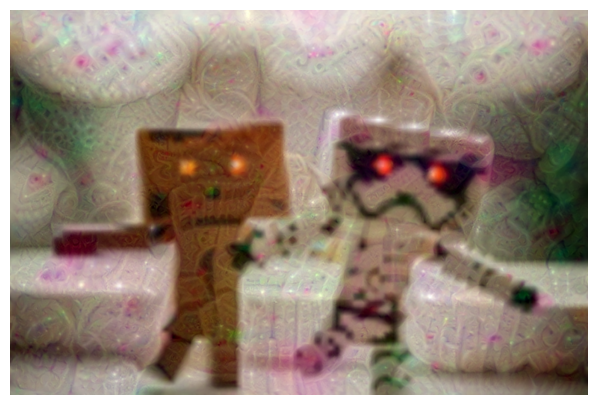

Saved DeepDream static image to: data/out-images/VGG16_EXPERIMENTAL_IMAGENET/figures_width_960_model_RESNET50_PLACES_365_layer5_pyrsize_5_pyrratio_1.8_iter_5_lr_0.03_shift_40_smooth_0.2.jpg



In [22]:
config['input'] = 'figures.jpg'
config['img_width'] = 960
config['model_name'] = SupportedModels.RESNET50.name
config['pretrained_weights'] = SupportedPretrainedWeights.PLACES_365.name
config['layers_to_use'] = ['layer5']  # layer34 was used
config['pyramid_size'] = 5
config['pyramid_ratio'] = 1.8
config['num_gradient_ascent_iterations'] = 5
config['lr'] = 0.03
config['spatial_shift_size'] = 40
config['smoothing_coefficient'] = 0.2

img = deep_dream_static_image(config)
dump_path = save_and_maybe_display_image(config, img)
print(f'Saved DeepDream static image to: {os.path.relpath(dump_path)}\n')

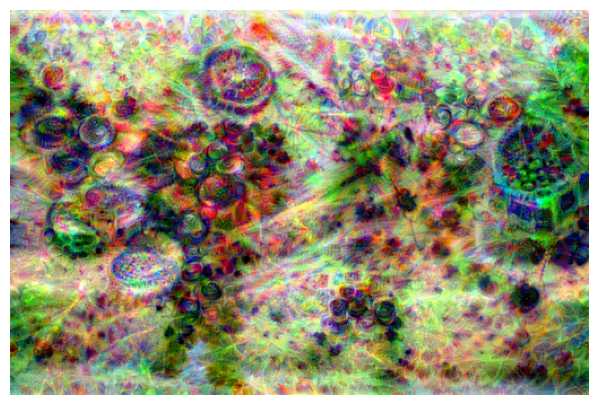

In [36]:

config['img_width'] = 512
config['input'] = 'figures.jpg'
config['use_noise'] = False
config['model_name'] = SupportedModels.RESNET50.name
config['pretrained_weights'] = SupportedPretrainedWeights.NSFW.name
config['layers_to_use'] = ['layer5', 'layer2']
config['pyramid_size'] = 4
config['pyramid_ratio'] = 1.9
config['num_gradient_ascent_iterations'] = 40
config['lr'] = 0.07
config['spatial_shift_size'] = 100
config['smoothing_coefficient'] = 0.6

img = deep_dream_static_image(config)
dump_path = save_and_maybe_display_image(config, img)
# print(f'Saved DeepDream static image to: {os.path.relpath(dump_path)}\n')